# Polaroid Dataset Exposure Equalization

## 0. Import Libraries

In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import statistics
import math
from numba import jit
import warnings
warnings.filterwarnings("ignore")

## 1. Polaroid Img Dataset --> Floating Point
Reference: https://stackoverflow.com/a/57327815

100%|██████████| 47/47 [00:04<00:00, 11.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


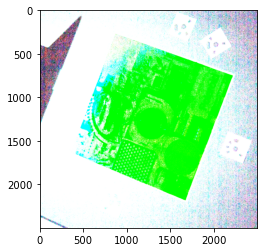

In [2]:
base_path = '../../img_dataset/polaroid_crop_best/images/'
img_floating_arr = []
img_names = os.listdir(base_path)
for i in tqdm(img_names):
    img = cv2.imread(base_path + i)
    fp_img = img.astype(np.float32) # convert into 32-bit floating point
    img_floating_arr.append(fp_img)

plt.imshow(img_floating_arr[0])
plt.show()

## 2. Counting Sort (Global Median Value)
Problem:
- Saving all pixel values to the single array and then taking a median cause a out of memory (limitations in system RAM)
- Take a median for each image and take a median of medians is biased

Solution:
- x and ln(x) has a proportional relationship, where x is [0, 255]
- Apply counting sort to x values first (to count with integer values), and then take the median, and take ln(median).

In [3]:
@jit
def pixel_count(img_floating_arr):
    count_sort = [0] * 257 # 1 to 256 (ignore 0th)
    for img in img_floating_arr:
        height, width, depth = img.shape
        for i in range(height):
            for j in range(width):
                b, g, r = img[i, j] # get current r, g, b value from pixel(i, j)
                count_sort[int(b) + 1] += 1
                count_sort[int(g) + 1] += 1
                count_sort[int(r) + 1] += 1
        
    return count_sort

count_sort = pixel_count(img_floating_arr)
median_idx = sum(count_sort) / 2
print(median_idx)
print(count_sort[:10])

440625000.0
[0, 240542452, 71366404, 65388317, 56550032, 46334828, 31484939, 24736896, 18980196, 16138674]


In [4]:
@jit
def median_odd(count_sort, median_idx):
    curr_idx = 0
    for i in range(1, len(count_sort)):
        curr_idx += count_sort[i]
        if curr_idx > median_idx: return i

@jit
def median_even(count_sort, median_idx):
    curr_idx = 0
    found = False # flag value
    first = None
    second = None
    for i in range(1, len(count_sort)):
        curr_idx += count_sort[i]
        if (found == False) and (curr_idx >= median_idx):
            found = True
            first = i
        elif (found == True) and (count_sort[i] != 0):
            second = i
            return (first + second) / 2.0
        elif (found == True) and (count_sort[i] == 0):
            continue
            

if median_idx % 2 == 0:
    MM = median_even(count_sort, int(median_idx))
else:
    MM = median_odd(count_sort, median_idx)

del(count_sort)
print(MM)

5.5


## 3. ln(each_pixel)
"`np.log` is ln, whereas `np.log10` is your standard base 10 log."

Reference: https://stackoverflow.com/a/10593175

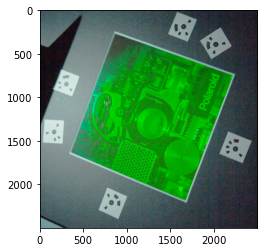

In [5]:
@jit
def pixel_ln(img_floating_arr):
    img_ln_arr = []
    for img in img_floating_arr:
        height, width, depth = img.shape
        for i in range(height):
            for j in range(width):
                b, g, r = img[i, j] # get current r, g, b value from pixel(i, j)
                # replace with natural log value, add 1 to the pixel value before taking a log
                img[i, j] = [np.log(b + 1), np.log(g + 1), np.log(r + 1)]
        img_ln_arr.append(img)
    return img_ln_arr

img_ln_arr = pixel_ln(img_floating_arr)
del(img_floating_arr) # free the memory

sample_log = img_ln_arr[0]
sample_log = cv2.normalize(sample_log, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
sample_log = sample_log.astype(np.uint8)
plt.imshow(sample_log)
plt.show()

## 4. Pixel(b, g, r) Median Value
M_i value stored in r, g, b three lists.

In [6]:
@jit
def pixel_median(img_ln_arr):
    idx = 0
    global_pixel = [] # median (r,g,b) of each image
    for img in img_ln_arr:
        idx += 1
        if idx % 10 == 0: print(idx)
        img_pixel = [] # store median(r,g,b) for a single image to take median
        height, width, depth = img.shape
        for i in range(height):
            for j in range(width):
                b, g, r = img[i, j] # get current r, g, b value from pixel(i, j)
                img_pixel.append(b)
                img_pixel.append(g)
                img_pixel.append(r)
        global_pixel.append(statistics.median(img_pixel)) # add single image's median value

    return global_pixel

global_pixel = pixel_median(img_ln_arr)

10
20
30
40


## 4. Pixel(b, g, r) Median Value Among Dataset
MM (r, g, b) values are computed (Global median value), already taken with counting sort in stpe 2.

In [7]:
MM = np.log(MM)
print(MM)

1.7047480922384253


## 5. Shift Pixel Values
E_i = MM (global median) - M_i (local median)

For i-th img, add E_i to each pixel value V

10
20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30
40


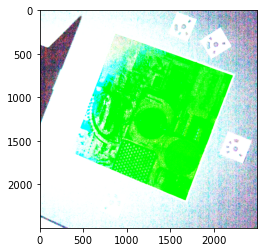

In [8]:
@jit
def pixel_shift(img_ln_arr):
    idx = 0
    for i in range(len(img_ln_arr)):
        idx += 1
        if idx % 10 == 0: print(idx)
        # if idx == 5: break # TESTING PURPOSES, run only first 5 imgs
        
        offset = MM - global_pixel[i] # get E_i for each r, g, b values
        img = img_ln_arr[i]
        height, width, depth = img.shape
        for p in range(height):
            for q in range(width):
                b, g, r = img[p, q] # get current r, g, b value from pixel(p, q)
                img[p, q] = [b + offset, g + offset, r + offset] # add E_i values to the pixel V(r,g,b)

    return img_ln_arr

img_shift_arr = pixel_shift(img_ln_arr)
del(global_pixel) # free system memory
del(img_ln_arr) # free system memory

plt.imshow(img_shift_arr[0])
plt.show()

## 6. Return (e^V)

In [9]:
@jit
def pixel_exp(img_shift_arr):
    for img in img_shift_arr:
        height, width, depth = img.shape
        for i in range(height):
            for j in range(width):
                b, g, r = img[i, j] # get current r, g, b value from pixel(i, j)
                img[i, j] = [math.exp(b) - 1, math.exp(g) - 1, math.exp(r) - 1] # replace with e^V
    return img_shift_arr

print(img_shift_arr[0][0][0])
img_final_arr = pixel_exp(img_shift_arr)
del(img_shift_arr) # free the memory
print(img_final_arr[0][0][0])

[1.5224265 1.704748  2.1102133]
[3.583333  4.4999995 7.250001 ]


[3.583333  4.4999995 7.250001 ]


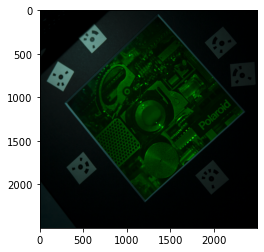

True

In [10]:
name_idx = 0
base_path = '../../img_dataset/polaroid_crop_best_log/images/'
for img in img_final_arr:
    final = (cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)).astype(np.uint8)
    cv2.imwrite(base_path + img_names[name_idx], final)
    name_idx += 1

print(img_final_arr[0][0][0])
plt.imshow(final)
plt.show()
cv2.imwrite('equalization.png', final)

## Misc.
1. Apply CLAHE
2. Apply histogram equalization

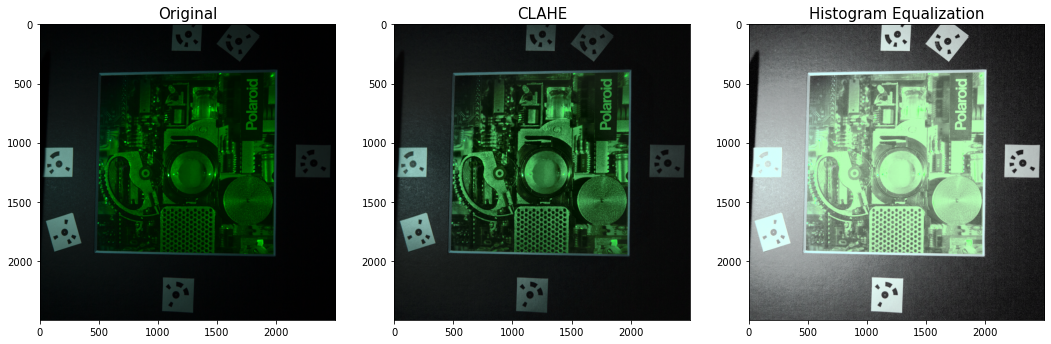

In [11]:
img_path = '../../img_dataset/polaroid_crop/images/911A8044.png'
img = cv2.imread(img_path)

# apply CLAHE: https://stackoverflow.com/a/47370615
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
lab_planes = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.0)
lab_planes[0] = clahe.apply(lab_planes[0])
lab = cv2.merge(lab_planes)
bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

# equalize histogram: https://stackoverflow.com/a/38312281
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

f, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].set_title(f'Original', fontsize = 15)
ax[0].imshow(img)
ax[1].set_title(f'CLAHE', fontsize = 15)
ax[1].imshow(bgr)
ax[2].set_title(f'Histogram Equalization', fontsize = 15)
ax[2].imshow(img_output)